# Snaike game with neural nets

## Importing modules

In [1]:
import pygame,sys
from pygame.locals import *
from random import randint
import math
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import tflearn
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import time
import matplotlib.pyplot as plt

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#colors
WHITE = (255, 255, 255)
BLACK=(0,0,0)

In [3]:
def desloc(x,y,ori):
    des=1
    if(ori=='r'):
        return (x+des,y)
    elif(ori=='l'):
        return (x-des,y)
    elif(ori=='u'):
        return (x,y-des)
    elif (ori=='d'):
        return (x,y+des)

In [4]:
def oriNumb(ori):
    
    if(ori=='r'):
        return 0
    elif(ori=='d'):
        return 1
    elif(ori=='l'):
        return 2
    elif(ori=='u'):
        return 3

def numbOri(numb):
    
    if(numb==0):
        return 'r'
    elif(numb==1):
        return 'd'
    elif(numb==2):
        return 'l'
    elif(numb==3):
        return 'u'    

In [5]:
class food(pygame.sprite.Sprite):
    
    def __init__(self,x,y,img):
        
        pygame.sprite.Sprite.__init__(self)
        self.image=img
        self.rect=self.image.get_rect()
        self.rect.x=x
        self.rect.y=y

In [6]:
#head
class head(pygame.sprite.Sprite):
    
    def __init__(self,x,y,img):
        
        pygame.sprite.Sprite.__init__(self)
        self.image=img
        self.rect=pygame.rect.Rect(x,y,int(img.get_width()*0.75),int(img.get_height()+0.75))
        self.orientation=''
        self.turns=[]
    
    def get_render_rect(self):
        
        return ((self.rect.x-int(self.image.get_width()*0.25)),(self.rect.y-int(self.image.get_height()*0.25)))

In [7]:
#body
class body(pygame.sprite.Sprite):
    def __init__(self,x,y,ori,img):
        
        pygame.sprite.Sprite.__init__(self)
        self.image=img
        self.rect=pygame.rect.Rect(x,y,int(img.get_width()*0.75),int(img.get_height()*0.75))
        self.orientation=ori
        self.turns=[]
    
    def move(self):
        
        if(len(self.turns)==0):
            self.rect.x,self.rect.y=desloc(self.rect.x,self.rect.y,self.orientation)
            
        else:
            turnx,turny,turno= self.turns[0]
            virtualx,virtualy=desloc(self.rect.x,self.rect.y,self.orientation)
            
            if(((self.orientation=='r' and virtualx>turnx) or (self.orientation=='l' and virtualx<turnx) 
               or (self.orientation=='u' and virtualy<turny) or (self.orientation=='d' and virtualy>turny))
              and self.orientation!=turno):
                
                self.rect.x,self.rect.y=desloc(self.rect.x,self.rect.y,turno)
                self.orientation=turno
                self.turns.pop(0)
                
            else:
                self.rect.x,self.rect.y=desloc(self.rect.x,self.rect.y,self.orientation)

    def get_render_rect(self):
        
        return ((self.rect.x-int(self.image.get_width()*0.25)),(self.rect.y-int(self.image.get_height()*0.25)))
                

In [8]:
#Snake
class Snake:
    
    def __init__(self,x,y,headIm,ori='r'):
        
        self.head=head(x,y,headIm)
        self.head.orientation=ori
        self.blocks=[]
        self.orientation=ori   
        self.headImg=headIm
        self.bodyImg=pygame.Surface((0,0))
        self.walls=[]
        
    def move(self,ori):
        
        if(ori!=self.orientation):
            #turn happened
            turn=(self.head.rect.x,self.head.rect.y,ori)
            for block in self.blocks:
                block.turns.append(turn)
            self.orientation=ori
            self.head.orientation=ori
   
        self.head.rect.x,self.head.rect.y=desloc(self.head.rect.x,self.head.rect.y,ori)
        
        for b in self.blocks:
            b.move()

    def createWalls(self,dim):
        
        r1=pygame.rect.Rect(0,-1,dim,1)
        r2=pygame.rect.Rect(-1,0,1,dim)
        r3=pygame.rect.Rect(dim,0,1,dim)
        r4=pygame.rect.Rect(0,dim,dim,1)
        self.walls.append(r1)
        self.walls.append(r2)
        self.walls.append(r3)
        self.walls.append(r4)
    
    def isAlive(self):
        
        head_rect=self.head.rect
        
        for bloc in self.blocks:
            if(head_rect.colliderect(bloc.rect)):
                return False
        
        for wall in self.walls:
            if(head_rect.colliderect(wall)):
                return False
        return True
    
    def calcBodyPosition(self,bloc):
        
        ori=bloc.orientation
        
        #values
        spacing=int(0.70*bloc.image.get_width())
        dist=spacing+bloc.image.get_width()
        
        #virtual values
        virtualx,virtualy=0,0
        
        if(ori=='r'):
            virtualx,virtualy=(bloc.rect.x-dist),(bloc.rect.y)

        elif(ori=='l'):
            virtualx,virtualy=(bloc.rect.x+dist),(bloc.rect.y)

        elif(ori=='u'):
            virtualx,virtualy=(bloc.rect.x),(bloc.rect.y+dist)

        elif(ori=='d'):
            virtualx,virtualy=(bloc.rect.x),(bloc.rect.y-dist)
        
        return (virtualx,virtualy)
    
    def addBlock(self):
        
        lastbloc=self.head
        
        if(len(self.blocks)>0):
            lastbloc=self.blocks[-1]
        bx,by=self.calcBodyPosition(lastbloc)
        nbody= body(bx,by,lastbloc.orientation,lastbloc.image)
        nbody.turns=list(lastbloc.turns)
        self.blocks.append(nbody)
        
    def eaten(self,food):
        
        if(self.head.rect.colliderect(food.rect)):
            return True
        return False
    
    
    def obstDist(self,ori):
        
        dx,dy=0,0
        if(ori==0):
            dx=1
        elif(ori==2):
            dx=-1
        elif(ori==3):
            dy=-1
        elif(ori==1):
            dy=1
        
        virtualx,virtualy=int(self.head.rect.x+(self.head.image.get_width()*0.5)),int(self.head.rect.y+(self.head.image.get_height()*0.5))
        flag=True
        while(flag):
            virtualx+=dx
            virtualy+=dy
            for bloc in self.blocks:
                bx,by=bloc.get_render_rect()
                sp=int(bloc.image.get_width()*0.7)
                nrect=pygame.rect.Rect(bx,by,(bloc.image.get_width()+sp),(bloc.image.get_height()+sp))
                if(nrect.collidepoint(virtualx,virtualy)):
                    flag=False
                    break
            
            if(flag):    
                for wall in self.walls:
                    if(wall.collidepoint(virtualx,virtualy)):
                        flag=False
                        break
        if(ori==0 or ori==2):
            return abs((self.head.rect.x-virtualx))
        elif(ori==1 or ori==3):
            return abs((self.head.rect.y-virtualy))

    
    def getAtr(self):
        
        nori=oriNumb(self.orientation)
        return [self.obstDist((nori+3)%4),self.obstDist(nori),self.obstDist((nori+1)%4)]
    
    def normalizeData(self,features):
        
        f=[]
        for fi in features:
            f.append([int(fi[0]/self.head.image.get_width()),int(fi[1]/self.head.image.get_width()),
                     int(fi[2]/self.head.image.get_width()), int(fi[3]),int(fi[4]),fi[5]])
        return f

In [9]:
def renderSnake(display,snake):
    
    headImg=snake.headImg
    bodyImg=snake.bodyImg
    
    #add head
    display.blit(headImg,snake.head.get_render_rect())
    
    #add body
    for body in snake.blocks:
        display.blit(bodyImg,body.get_render_rect()) 
        

In [10]:
def renderFood(display,food):
    
    display.blit(food.image,food.rect)

In [11]:
def newFood(foodImg,dim):
    
    fos=5
    return food(randint(fos,(dim-foodImg.get_width()-fos)),randint(fos,(dim-foodImg.get_height()-fos)),foodImg)

In [12]:
def foodPos(snake,food):
    
    hip=math.sqrt((snake.head.rect.x-food.rect.x)**2+(snake.head.rect.y-food.rect.y)**2)
    cat=0
    if(snake.orientation=='r'):
        cat=food.rect.x-snake.head.rect.x
        if(food.rect.y>=snake.head.rect.y):
            return (360-math.degrees(np.arccos(cat/hip))),hip
        else:
            return math.degrees(np.arccos(cat/hip)),hip

    elif(snake.orientation=='l'):
        cat=snake.head.rect.x-food.rect.x
        if(food.rect.y<=snake.head.rect.y):
            return (360-math.degrees(np.arccos(cat/hip))),hip
        else:
            return math.degrees(np.arccos(cat/hip)),hip
    
    elif(snake.orientation=='u'):
        cat=snake.head.rect.y-food.rect.y
        if(food.rect.x<=snake.head.rect.x):
            return (360-math.degrees(np.arccos(cat/hip))),hip
        else:
            return math.degrees(np.arccos(cat/hip)),hip
    
    elif(snake.orientation=='d'):
        cat=food.rect.y-snake.head.rect.y
        if(food.rect.x>=snake.head.rect.x):
            return (360-math.degrees(np.arccos(cat/hip))),hip
        else:
            return math.degrees(np.arccos(cat/hip)),hip
     

In [13]:
'''
#reset files

pickle.dump( [], open( "features.fer", "wb" ) )    
pickle.dump( [], open( "tags.fer", "wb" ) )
'''

'\n#reset files\n\npickle.dump( [], open( "features.fer", "wb" ) )    \npickle.dump( [], open( "tags.fer", "wb" ) )\n'

In [14]:
def calcTag(lastori,ori):
    
    resp=oriNumb(ori)-oriNumb(lastori)
    if((lastori=='u' and ori=='r')):
        resp=1
    elif((lastori=='r' and ori=='u')):
        resp=-1
    return resp

In [15]:
def Create_Classifier(name):
	if(name=='LogReg'):
		return linear_model.LogisticRegression(n_jobs=1, C=1e5)
	elif(name=='KNN'):
		return KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine')
	elif(name=='NB'):
		return MultinomialNB(alpha=0.01)
	elif(name=='MLPerceptron'):
		return MLPClassifier()
	else:
		raise NameError('Classifier Unavailable')

In [16]:
#Tensor Flow 

def fully_connected_layer(input, n_inp, n_out, relu=True):
    
    w=tf.Variable(tf.truncated_normal([n_inp,n_out], stddev=0.05))
    b=tf.Variable(tf.constant(0.05,shape=[n_out]))
    
    layer=tf.matmul(input,w)+b
    
    if(relu):
        layer=tf.nn.relu(layer)
    return layer

In [17]:
class SampleGenerator:
    
    def __init__(self,features,tags):
        
        self.ex_indices=[]
        self.feat=features
        self.tags=tags
    
    def getBatch(self,batch_size):
        
        count=0
        f=[]
        t=[]
        while(count<batch_size):
            
            if(len(self.ex_indices)==len(self.tags)):
                self.ex_indices=[]
            
            i=randint(0,len(self.tags)-1)
            if(i not in self.ex_indices):
                self.ex_indices.append(i)
                f.append(self.feat[i])
                t.append(self.tags[i])
                count+=1
        
        t=np.array(t)
        zer= np.zeros((batch_size,3))
        
        for i in range(len(t)):
            aux=t[i]
            zer[i][aux]=1
            
        f=np.array(f)
        return f, zer

In [18]:
#init
print("Initializing game")
pygame.init()
dim=300
displaysurf=pygame.display.set_mode((dim,dim))
pygame.display.set_caption('Snaike')
fpsClock = pygame.time.Clock()
FPS = 60
framecount=0


#emilia variables
emiliaImg = pygame.image.load('blue.png')
emiliaSnake = Snake(int(dim/2)+100,int(dim/2)+100,emiliaImg,ori='u')
emiliaSnake.createWalls(dim)

#subaro
subaroImg=pygame.image.load('blue.png')
emiliaSnake.bodyImg=subaroImg

#game over
gameoverImg=pygame.image.load('gameover.jpg')

#food
foodImg=pygame.image.load('hamb.png')
foood=newFood(foodImg,dim)

#orientation
lastorientation=emiliaSnake.orientation
orientation=emiliaSnake.orientation
gameOverFlag=False



Initializing game


In [27]:
#Neural net
print("Opening config files")
#training features and tags
features=pickle.load( open( "features.fer", "rb" ) )
tags=pickle.load( open("tags.fer","rb"))
print("Features: ", len(features))

features=emiliaSnake.normalizeData(features)
features=[[x[0],x[1],x[2],x[3]] for x in features]
tags=[x+1 for x in tags]
print("Test-split")
#Training and test features
X_train, X_test, y_train, y_test = train_test_split( features, tags, test_size=0.10, random_state=42)
diist=[x[3] for x in features]
#plt.plot(features, tags,'ro')
#plt.show()

print("Smoting")
#Smote
sm = SMOTE(random_state=42)
X_train,y_train=sm.fit_sample(X_train,y_train)
print("Features: ", len(X_train))
'''
print("Training model ...")
featz=len(features[0])
outz=3
l1_neurons=30

#Neural net config
x=tf.placeholder(tf.float32,shape=[None,featz], name='x')
l1=fully_connected_layer(x,featz,l1_neurons)
l2=fully_connected_layer(l1,l1_neurons,outz,relu=False)
softmax=tf.nn.softmax(l2)
y_pred_cls=tf.argmax(softmax,axis=1)
y_true = tf.placeholder(tf.float32, shape=[None, 3], name='y_true')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=l2,labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#Accuracy measures
y_true_cls = tf.argmax(y_true, axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
'''

Opening config files
Features:  310


IndexError: list index out of range

In [20]:
#Session
session = tf.Session()
session.run(tf.global_variables_initializer())

In [21]:
'''
#Optimization function
sampleGenerator=SampleGenerator(X_train,y_train)
batch_size=64

def optimize(num_iterations):
    
    for i in range(num_iterations):
        
        f,t=sampleGenerator.getBatch(batch_size)
        feed_dict_train={ x:f, y_true:t}
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
            if(acc>=0.80):
                break
'''

'\n#Optimization function\nsampleGenerator=SampleGenerator(X_train,y_train)\nbatch_size=64\n\ndef optimize(num_iterations):\n    \n    for i in range(num_iterations):\n        \n        f,t=sampleGenerator.getBatch(batch_size)\n        feed_dict_train={ x:f, y_true:t}\n        session.run(optimizer, feed_dict=feed_dict_train)\n        \n        if i % 100 == 0:\n            # Calculate the accuracy on the training-set.\n            acc = session.run(accuracy, feed_dict=feed_dict_train)\n\n            # Message for printing.\n            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"\n\n            # Print it.\n            print(msg.format(i + 1, acc))\n            if(acc>=0.80):\n                break\n'

In [22]:
'''
#Running the graph
optimize(7500)
'''

'\n#Running the graph\noptimize(7500)\n'

In [23]:
'''
pred_dict={x:X_test}
predictions=session.run(y_pred_cls,feed_dict=pred_dict)

print(classification_report(y_test,predictions))
'''

'\npred_dict={x:X_test}\npredictions=session.run(y_pred_cls,feed_dict=pred_dict)\n\nprint(classification_report(y_test,predictions))\n'

In [24]:
#AI move
def aiMove(emiliaSnake,foood,orientation,framecount):
        
    if(framecount==0):
        atr1,atr2,atr3=emiliaSnake.getAtr()
        ang,hip= foodPos(emiliaSnake,foood)
            
        run_dict={x:[[atr1,atr2,atr3,ang]]}
        mv=session.run(y_pred_cls,feed_dict=run_dict)-1
        print(mv)
        if(orientation=='u' and mv==1):
            orientation='r'
        elif(orientation=='r' and mv==-1):
            orientation='u'
        else:
            orientation=numbOri(mv+oriNumb(orientation))
        print(orientation)
    
    return orientation

In [25]:
#game loop
print("game starts")
while True:   
    displaysurf.fill(WHITE)
    
    for event in pygame.event.get():
        if event.type== QUIT:
            pickle.dump( features, open( "features.fer", "wb" ) )    
            pickle.dump( tags, open( "tags.fer", "wb" ) )
            pygame.quit()
            sys.exit()
        elif event.type==KEYDOWN:
            if event.key==K_UP and orientation!='d':
                orientation='u'
            elif event.key==K_DOWN and orientation!='u':
                orientation='d'
            elif event.key==K_RIGHT and orientation!='l':
                orientation='r'
            elif event.key==K_LEFT and orientation!='r':
                orientation='l'
            elif event.key==K_f:
                emiliaSnake = Snake(int(dim/2),int(dim/2),emiliaImg)
                emiliaSnake.createWalls(dim)
                emiliaSnake.bodyImg=subaroImg
                gameOverFlag=False
            elif event.key==K_n:
                pickle.dump( features, open( "features.fer", "wb" ) )
                pickle.dump( tags, open( "tags.fer", "wb" ) )
                pygame.quit()
                sys.exit()
    
    framecount=(framecount+1)%30
    
    atr1,atr2,atr3,ang,hip=0,0,0,0,0
    #emilia motion
    if(emiliaSnake.isAlive()):
        
        '''
        #AI move
        if(True):
            atr1,atr2,atr3=emiliaSnake.getAtr()
            ang,hip= foodPos(emiliaSnake,foood)
            run_feat=[[int(atr1/emiliaSnake.head.image.get_width()),int(atr2/emiliaSnake.head.image.get_width()),int(atr3/emiliaSnake.head.image.get_width()),int(ang)]]
            run_dict={x:run_feat}
            mv=session.run(y_pred_cls,feed_dict=run_dict)-1
            if(orientation=='u' and mv==1):
                orientation='r'
            elif(orientation=='r' and mv==-1):
                orientation='u'
            else:
                orientation=numbOri(mv+oriNumb(orientation))
        '''
        emiliaSnake.move(orientation)
    
    if(not emiliaSnake.isAlive()):
        gameOverFlag=True
        
        displaysurf.blit(gameoverImg, (int((dim-gameoverImg.get_width())/2),(int((dim-gameoverImg.get_height())/2)-50)))
        pygame.display.update()

    if(emiliaSnake.eaten(foood)):
        
        foood=newFood(foodImg,dim)
        emiliaSnake.addBlock()
    
    if(not gameOverFlag):
        
        if(framecount==0 or lastorientation!=orientation):
            
            atr1,atr2,atr3=emiliaSnake.getAtr()
            ang,hip= foodPos(emiliaSnake,foood)
            
            features.append([atr1,atr2,atr3,ang,hip,oriNumb(orientation)])
            rio=calcTag(lastorientation,orientation)
            tags.append(rio)
            lastorientation=orientation
        
        renderSnake(displaysurf,emiliaSnake)
        renderFood(displaysurf,foood)
        pygame.display.update()
        
    fpsClock.tick(FPS)
    

            

game starts


SystemExit: 

C:\Users\Fernando\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


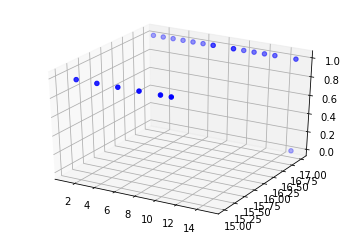

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xp=[int(x[1])for x in X_train]
yp=[int(y[0])for y in X_train]

ax.scatter(xp, yp, y_train, c='b', marker='o')
plt.show()